# SIDES Simulation

This directory uses [SIDES](https://gitlab.lam.fr/mbethermin/sides-public-release/-/tree/main/PYSIDES) to generate a simulated catalog and corresponding maps. 

The function of the simulated maps/catalog is to compare the positions/fluxes that the maps are composed of and the mean flux density estimated by SIMSTACK, i.e., is what goes in what comes out?



In [169]:
# Standard modules
import pdb
import os
import sys
import pandas as pd
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import gridspec
from lmfit import Parameters, minimize, fit_report
import astropy.units as u
import astropy.cosmology.units as cu
from astropy.cosmology import WMAP9

import warnings
warnings.filterwarnings("ignore")

sys.path.append("../../../..")
from simstacktoolbox import SimstackToolbox

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

## Run script to generate maps

#### Generating maps is relatively simple.  The script gen_V22_maps.py is a modification of the script gen_Herschel_maps.py

from pysides.make_maps import *
from pysides.load_params import *
from astropy.table import Table

params_sides = load_params('PAR_FILES/SIDES_from_original.par')

params_maps = load_params("PAR_FILES/V22_maps.par")

cat = Table.read(params_maps["sides_cat_path"])
cat = cat.to_pandas()

make_maps(cat, params_maps, params_sides)

#### and V22_maps.par is a modified version of HERSCHEL_maps.par, adding MIPS24.  

filter_list = ['MIPS24','PACS100','PACS160','SPIRE250','SPIRE350','SPIRE500']

beam_fwhm_list = [5.5, 7.7, 12.0, 18.2, 24.9, 36.3]

pixel_size = [1.2, 1.2, 2.4, 5., 5., 5.]

#### After setting up paths and light editing of file generating maps is simply:

In [2]:
run gen_V22_maps.py

Generate the map for MIPS24...
Set World Coordinates System...
Convolve the map by the beam...
Write D:\simulations\sides\maps\pySIDES_from_original_V22_MIPS24_smoothed_Jy_beam.fits...
Generate the map for PACS100...
Set World Coordinates System...
Convolve the map by the beam...
Write D:\simulations\sides\maps\pySIDES_from_original_V22_PACS100_smoothed_Jy_beam.fits...
Generate the map for PACS160...
Set World Coordinates System...
Convolve the map by the beam...
Write D:\simulations\sides\maps\pySIDES_from_original_V22_PACS160_smoothed_Jy_beam.fits...
Generate the map for SPIRE250...
Set World Coordinates System...
Convolve the map by the beam...
Write D:\simulations\sides\maps\pySIDES_from_original_V22_SPIRE250_smoothed_Jy_beam.fits...
Generate the map for SPIRE350...
Set World Coordinates System...
Convolve the map by the beam...
Write D:\simulations\sides\maps\pySIDES_from_original_V22_SPIRE350_smoothed_Jy_beam.fits...
Generate the map for SPIRE500...
Set World Coordinates System..

# Import simulated catalog

The same catalog used to generate simulated images can be used to analyze stacked flux results and investigate biases via simulations.

In [2]:
# Import table with astropy
CATSPATH = 'D:\\simulations\\sides\\'
path_sides = os.path.join(CATSPATH, "pySIDES_from_original.fits")
if os.path.isfile(path_sides):
    print('Open ',path_sides)
    with fits.open(path_sides) as hdul:
        hdul.verify('fix')
        sides_catalog = hdul[1].data
else:
    print(path_sides, ' not found')

Open  D:\simulations\sides\pySIDES_from_original.fits


In [3]:
# Read into pandas DataFrame
sides_df = pd.DataFrame(sides_catalog)

In [4]:
sides_df.keys()

Index(['redshift', 'ra', 'dec', 'Mhalo', 'Mstar', 'qflag', 'SFR', 'issb', 'mu',
       'Dlum', 'Umean', 'LIR', 'S24', 'S70', 'S100', 'S160', 'S250', 'S350',
       'S500', 'S850', 'S1100', 'S2000', 'LFIR', 'SMIPS24', 'SPACS70',
       'SPACS100', 'SPACS160', 'SSPIRE250', 'SSPIRE350', 'SSPIRE500',
       'SNIKA1200', 'SNIKA2000', 'LprimCO10', 'ICO10', 'ICO21', 'ICO32',
       'ICO43', 'ICO54', 'ICO65', 'ICO76', 'ICO87', 'LCII_Lagache',
       'ICII_Lagache', 'LCII_de_Looze', 'ICII_de_Looze', 'ICI10', 'ICI21'],
      dtype='object')

#### Define columns to keep and write CSV

In [5]:
columns = ['redshift','ra','dec','Mstar','qflag','SFR','LIR','SMIPS24','S100','S160','SSPIRE250','SSPIRE350','SSPIRE500','S850']
sides_df[columns].head()

,redshift,ra,dec,Mstar,qflag,SFR,LIR,SMIPS24,S100,S160,SSPIRE250,SSPIRE350,SSPIRE500,S850
0,0.027082,1.386314,0.578664,1.166001e+10,False,2.131869,2.131869e+10,0.031750,0.978360,0.992486,0.500539,0.215010,0.078771,0.013884
1,0.029516,0.454959,1.145274,2.612670e+10,True,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.028948,0.653517,1.053531,4.891516e+09,False,0.921371,9.213706e+09,0.016367,0.338908,0.301663,0.140840,0.057914,0.020618,0.003558
3,0.027158,0.931048,0.651234,1.876074e+09,True,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.028611,0.787421,0.940826,1.672992e+09,False,0.268678,2.686784e+09,0.004879,0.099181,0.086771,0.040053,0.016370,0.005806,0.001000


In [6]:
overwrite_catalog = False
path_sides_csv = os.path.join(os.environ['CATSPATH'], "cosmos","sides_full.csv")
if overwrite_catalog or not os.path.isfile(path_sides_csv):
    print('Writing', path_sides_csv)
    sides_df[columns].dropna().to_csv(path_sides_csv)

# Fit SEDs to every star-forming galaxy and save as CSV

In [27]:
Mcut = 8.5
sfg_catalog = sides_df[(sides_df['qflag']==False) & (np.log10(sides_df['Mstar'])>=Mcut)][["redshift","ra","dec","Mstar","qflag","SFR","LIR","SMIPS24","S100","S160","SSPIRE250","SSPIRE350","SSPIRE500","S850"]]

In [28]:
sfg_catalog.head()

,redshift,ra,dec,Mstar,qflag,SFR,LIR,SMIPS24,S100,S160,SSPIRE250,SSPIRE350,SSPIRE500,S850
0,0.027082,1.386314,0.578664,1.166001e+10,False,2.131869,2.131869e+10,0.031750,0.978360,0.992486,0.500539,0.215010,0.078771,0.013884
2,0.028948,0.653517,1.053531,4.891516e+09,False,0.921371,9.213706e+09,0.016367,0.338908,0.301663,0.140840,0.057914,0.020618,0.003558
4,0.028611,0.787421,0.940826,1.672992e+09,False,0.268678,2.686784e+09,0.004879,0.099181,0.086771,0.040053,0.016370,0.005806,0.001000
5,0.030565,1.024233,1.341723,4.972536e+08,False,0.110024,1.100238e+09,0.001730,0.036480,0.032918,0.015433,0.006376,0.002276,0.000395
6,0.027382,1.168631,0.542636,6.630631e+08,False,0.025710,2.570981e+08,0.000451,0.011006,0.010512,0.005121,0.002158,0.000781,0.000136


### Import SED fitting codes

In [9]:
def black( nu_in, T):
    # h = 6.623e-34     ; Joule*s
    # k = 1.38e-23      ; Joule/K
    # c = 3e8           ; m/s
    # (2*h*nu_in^3/c^2)*(1/( exp(h*nu_in/k*T) - 1 )) * 10^29

    a0 = 1.4718e-21  # 2*h*10^29/c^2
    a1 = 4.7993e-11  # h/k

    num = a0 * nu_in ** 3.0
    den = np.exp(a1 * np.outer(1.0 / T, nu_in)) - 1.0
    ret = num / den

    return ret

In [10]:
def graybody_fn(theta, x, alphain=2.0, betain=1.8):
    A, T = theta

    c_light = 299792458.0  # m/s

    nu_in = np.array([c_light * 1.e6 / wv for wv in x])
    ng = np.size(A)

    base = 2.0 * (6.626) ** (-2.0 - betain - alphain) * (1.38) ** (3. + betain + alphain) / (2.99792458) ** 2.0
    expo = 34.0 * (2.0 + betain + alphain) - 23.0 * (3.0 + betain + alphain) - 16.0 + 26.0
    K = base * 10.0 ** expo
    w_num = 10 ** A * K * (T * (3.0 + betain + alphain)) ** (3.0 + betain + alphain)
    w_den = (np.exp(3.0 + betain + alphain) - 1.0)
    w_div = w_num / w_den
    nu_cut = (3.0 + betain + alphain) * 0.208367e11 * T
    graybody = np.reshape(10 ** A, (ng, 1)) * nu_in ** np.reshape(betain, (ng, 1)) * black(nu_in, T) / 1000.0
    powerlaw = np.reshape(w_div, (ng, 1)) * nu_in ** np.reshape(-1.0 * alphain, (ng, 1))
    graybody[np.where(nu_in >= np.reshape(nu_cut, (ng, 1)))] = \
        powerlaw[np.where(nu_in >= np.reshape(nu_cut, (ng, 1)))]

    return graybody

In [11]:
def fast_sed(m, wavelengths):

    v = m.valuesdict()
    A = np.asarray(v['A'])
    T = np.asarray(v['T_observed'])
    betain = np.asarray(v['beta'])
    alphain = np.asarray(v['alpha'])
    theta_in = A, T

    return graybody_fn(theta_in, wavelengths, alphain=alphain, betain=betain)

In [12]:
def find_sed_min(params, wavelengths, fluxes, covar=None):

    graybody = fast_sed(params, wavelengths)[0]
    delta_y = (fluxes - graybody)

    if (covar is None) or (np.sum(covar) == 0):
        return delta_y
    else:
        if np.shape(covar) == np.shape(fluxes):
            return delta_y ** 2 / covar
        else:
            return np.matmul(delta_y**2, np.linalg.inv(covar))

In [13]:
def fast_sed_fitter(wavelengths, fluxes, covar=None, betain=1.8, alphain=2.0, redshiftin=0, stellarmassin=None):

    t_in = (23.8 + 2.7 * redshiftin + 0.9 * redshiftin ** 2) / (1 + redshiftin)
    if stellarmassin is not None:
        a_in = -47 - redshiftin*0.05 + 11 * (stellarmassin / 10)
    else:
        a_in = -35.0
        
    fit_params = Parameters()
    fit_params.add('A', value=a_in, vary=True)
    fit_params.add('T_observed', value=t_in, vary=True)
    fit_params.add('beta', value=betain, vary=False)
    fit_params.add('alpha', value=alphain, vary=False)

    fluxin = fluxes
    try:
        sed_params = minimize(find_sed_min, fit_params,
                              args=(wavelengths,),
                              kws={'fluxes': fluxin, 'covar': covar})
        m = sed_params.params
    except:
        m = fit_params

    return m

In [14]:
def estimate_single_sed(wavelengths, fluxes, z=0, m=None):

    sed_params = fast_sed_fitter(wavelengths, fluxes, covar=None, redshiftin=z, stellarmassin=m)
    
    return sed_params

In [15]:
def estimate_sides_seds(catalog, wv_cat = ["SMIPS24","S100","S160","SSPIRE250","SSPIRE350","SSPIRE500"], wavelengths = [24, 100, 160, 250, 350, 500]):
 
    a_array = np.zeros(len(catalog))
    t_array = np.zeros(len(catalog))
    trf_array = np.zeros(len(catalog))

    print("Fitting {} objects".format(len(catalog)))
    for i in range(len(catalog)):
        fluxes = catalog[wv_cat].iloc[i].values
        zin = catalog['redshift'].iloc[i]
        mm = catalog['Mstar'].iloc[i]
        single_sed_params = estimate_single_sed(wavelengths, fluxes) #, zin, np.log10(mm))
        a_array[i] = single_sed_params['A'].value
        t_array[i] = single_sed_params['T_observed'].value
        trf_array[i] = single_sed_params['T_observed'].value*(1+zin)
        
    catalog['Ain'] = a_array
    catalog['Tobs'] = t_array
    catalog['Trf'] = trf_array
    
    return catalog

In [29]:
catalog_with_trf = estimate_sides_seds(sfg_catalog)

Fitting 724790 objects


In [17]:
catalog_with_trf.head()

,redshift,ra,dec,Mstar,qflag,SFR,LIR,SMIPS24,S100,S160,SSPIRE250,SSPIRE350,SSPIRE500,S850,Ain,Tobs,Trf
0,0.027082,1.386314,0.578664,1.166001e+10,False,2.131869,2.131869e+10,0.031750,0.978360,0.992486,0.500539,0.215010,0.078771,0.013884,-33.448240,23.838945,24.484551
2,0.028948,0.653517,1.053531,4.891516e+09,False,0.921371,9.213706e+09,0.016367,0.338908,0.301663,0.140840,0.057914,0.020618,0.003558,-34.070478,25.412192,26.147824
4,0.028611,0.787421,0.940826,1.672992e+09,False,0.268678,2.686784e+09,0.004879,0.099181,0.086771,0.040053,0.016370,0.005806,0.001000,-34.625885,25.639175,26.372738
7,0.027862,0.953034,0.135157,3.129536e+09,False,0.366717,3.667170e+09,0.006763,0.147761,0.137267,0.065616,0.027400,0.009853,0.001718,-34.378675,24.883060,25.576352
34,0.038581,0.486818,1.373688,3.277258e+10,False,0.681084,6.810841e+09,0.004888,0.153104,0.165012,0.085557,0.037465,0.013870,0.002472,-34.182750,23.212420,24.107979


In [30]:
overwrite_catalog = False
path_sides_csv = os.path.join(os.environ['CATSPATH'], "cosmos","sides_sfg_gt_8p5_tdust.csv")
if overwrite_catalog or not os.path.isfile(path_sides_csv):
    catalog_with_trf.to_csv(path_sides_csv)

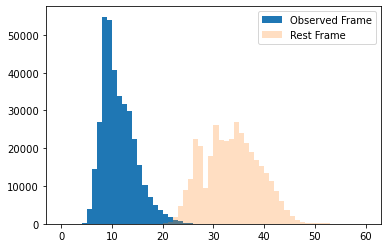

In [26]:
tarr = np.linspace(0,60,61)
plt.hist(catalog_with_trf['Tobs'],bins=tarr,label='Observed Frame');
plt.hist(catalog_with_trf['Trf'],bins=tarr,alpha=0.25,label='Rest Frame');
plt.legend();

In [126]:
def flux_model(z, m, zm, mm, b):
    return zm*z + mm*m + b

def flux_model_min(params, redshift, mass, fluxes, covar=None):

    v = params.valuesdict()
    zm = np.asarray(v['z_slope'])
    mm = np.asarray(v['m_slope'])
    b = np.asarray(v['offset'])
    
    #model = zm*redshift + mm*mass + b
    model = flux_model(redshift, mass, zm, mm, b)

    delta_y = (fluxes - model)

    if (covar is None) or (np.sum(covar) == 0):
        return delta_y
    else:
        if np.shape(covar) == np.shape(fluxes):
            return delta_y ** 2 / covar
        else:
            return np.matmul(delta_y**2, np.linalg.inv(covar))

In [161]:
fit_filename = 'flux_model_dict.pkl'
SimstackToolbox.save_to_pickles(os.path.join(CATSPATH,fit_filename), params_dict)
print('Saving', os.path.join(CATSPATH,fit_filename))

Saving D:\simulations\sides\flux_model_dict.pkl


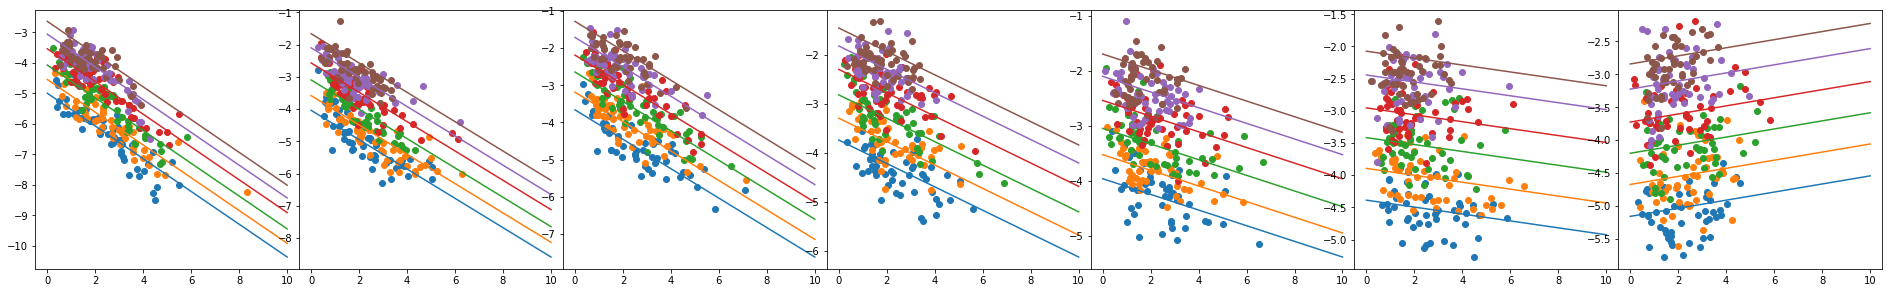

In [128]:
band=['SMIPS24','S100','S160','SSPIRE250','SSPIRE350','SSPIRE500','S850']
#band=['SMIPS24','S100',]
wlen=len(band)
hm = [8.5,9,9.5,10,10.5,11,12]
xmod = np.linspace(0,10,100)

width_ratios = [i for i in np.ones(wlen)]
gs = gridspec.GridSpec(1, wlen, width_ratios=width_ratios,
                       wspace=0.0, hspace=0.0, top=0.95, bottom=0.05, left=0.17, right=0.845)
fig = plt.figure(figsize=(38, 4))
#fig = plt.figure(figsize=(12, 4))

idm = pd.cut(np.log10(catalog_with_trf['Mstar']), bins=hm, labels=False, include_lowest=True)
nplot = 50

params_dict = {}
for iwv, wv in enumerate(band):
    
    fit_params = Parameters()    
    zs_in = -(8-3)/7
    ms_in = 3/(11.5-8.75)
    off_in = -15
    fit_params.add('z_slope', value=zs_in, vary=True)
    fit_params.add('m_slope', value=ms_in, vary=True)
    fit_params.add('offset', value=off_in, vary=True)
    
    nfit = 10000
    indp = np.random.choice(catalog_with_trf.index, size=nfit)
    xp = catalog_with_trf.loc[indp]['redshift']
    mp = np.log10(catalog_with_trf.loc[indp]['Mstar'])
    yp = catalog_with_trf.loc[indp][band[iwv]]
    sed_params = minimize(flux_model_min, fit_params,
                  args=(xp, mp,),
                  kws={'fluxes': np.log10(yp)})
    #print(sed_params.params)
    mm = sed_params.params['m_slope'].value
    zm = sed_params.params['z_slope'].value
    b = sed_params.params['offset'].value
    
    params_dict[wv]=sed_params
    
    for i in np.unique(idm):
        ax = plt.subplot(gs[0, iwv])
        indp = np.random.choice(catalog_with_trf[idm == i].index, size=np.min([nplot,np.sum(idm == i)]))
        xp = catalog_with_trf.loc[indp]['redshift']
        mp = np.log10(catalog_with_trf.loc[indp]['Mstar'])
        yp = catalog_with_trf.loc[indp][band[iwv]]
        ax.scatter(xp,np.log10(yp))

        m_in = np.mean(mp)        
        ax.plot(xmod, flux_model(xmod, m_in*np.ones_like(xmod), zm, mm, b))

In [191]:
p = params_dict['S850']
mm = p.params['m_slope'].value
zm = p.params['z_slope'].value
b = p.params['offset'].value

In [192]:
10**flux_model(5, np.log10((10**10.5)*.4), zm, mm, b) / 10**flux_model(5, 10.5, zm, mm, b)

0.410768785718031

In [170]:
z = 8.5 * cu.redshift
z.to(u.Mpc, cu.redshift_distance(WMAP9, kind="comoving"))  

<Quantity 9317.20716661 Mpc>

In [174]:
z1 = 6
z2 = 1

In [175]:
(z2 * cu.redshift).to(u.Mpc, cu.redshift_distance(WMAP9, kind="comoving")) / (z1 * cu.redshift).to(u.Mpc, cu.redshift_distance(WMAP9, kind="comoving"))  

<Quantity 0.39773987>